### 1. Set-up

#### 1.1 Imports

In [67]:
# Imports
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import math
import time
import numpy as np
import sys
import argparse
import os
import matplotlib.pyplot as plt
import pandas as pd
import math

#### 1.2 CUDA

In [68]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### 2. Data Pre-Processing

#### 2.1 Helper Functions

In [69]:
# Encoding and decoding
def decode(vocab,corpus):
    
    text = ''
    for i in range(len(corpus)):
        wID = corpus[i]
        text = text + vocab[wID] + ' '
    return(text)

def encode(words,text):
    corpus = []
    tokens = text.split(' ')
    for t in tokens:
        try:
            wID = words[t][0]
        except:
            wID = words['<unk>'][0]
        corpus.append(wID)
    return(corpus)

def read_encode(file_name,vocab,words,corpus,threshold):
    
    wID = len(vocab)
    
    if threshold > -1:
        with open(file_name,'rt', encoding='utf8') as f:
            for line in f:
                line = line.replace('\n','')
                tokens = line.split(' ')
                for t in tokens:
                    try:
                        elem = words[t]
                    except:
                        elem = [wID,0]
                        vocab.append(t)
                        wID = wID + 1
                    elem[1] = elem[1] + 1
                    words[t] = elem

        temp = words
        words = {}
        vocab = []
        wID = 0
        words['<unk>'] = [wID,100]
        vocab.append('<unk>')
        for t in temp:
            if temp[t][1] >= threshold:
                vocab.append(t)
                wID = wID + 1
                words[t] = [wID,temp[t][1]]
            
                    
    with open(file_name,'rt', encoding='utf8') as f:
        for line in f:
            line = line.replace('\n','')
            tokens = line.split(' ')
            for t in tokens:
                try:
                    wID = words[t][0]
                except:
                    wID = words['<unk>'][0]
                corpus.append(wID)
                
    return [vocab,words,corpus]

def plot_data(x, y1, y2, xlabel, ylabel, title, color1, color2, label1, label2):
    plt.plot(x, y1, color1, label=label1)
    plt.plot(x, y2, color2, label=label2)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.show()

#### 2.2 Create ngrams

In [70]:
def split_bios(data, words):
  fake_val, real_val = words["[FAKE]"][0], words["[REAL]"][0]
  fake_list = (data == fake_val)
  real_list = (data == real_val)
  target_indices = (fake_list + real_list).nonzero()
  bios_list = []
  start_i = 0

  for end_i in target_indices:
    bio = data[start_i:end_i+1]
    bios_list.append(bio)

    start_i = end_i + 1

  return bios_list

def clean_bios(bios, words):
  for bio_i in range(len(bios)):
    # Remove new lines and punctuation
    new_line_idx = words[''][0]
    comma_idx = words[','][0]
    period_idx = words['.'][0]
    colon_idx = words[':'][0]
    semicolon_idx = words[';'][0]

    punctuation_indices = [new_line_idx, comma_idx, period_idx, colon_idx, semicolon_idx]

    bios[bio_i] = list(filter(lambda x: x not in punctuation_indices, bios[bio_i]))

  return bios

def create_ngrams(bios, words, ngram_size):
  ngram_list = []

  for bio_i, bio in enumerate(bios):
    bio_len = len(bio)
    i = 0
    
    while i < bio_len - ngram_size:
      start, stop = i, i+ngram_size
      context = torch.tensor(bio[start:stop]).detach().to(device)
      label = torch.tensor(bio[stop]).detach().to(device)

      ngram = [context, label]
      ngram_list.append(ngram)

      i += 1

  return ngram_list


#### 2.3 Data Loader

In [71]:
class NgramDataset(Dataset):
    def __init__(self, ngrams_data):
        self.ngrams_data_df = pd.DataFrame(ngrams_data, columns=("context", "label"))
        self.context = self.ngrams_data_df["context"]
        self.label = self.ngrams_data_df["label"]

    def __len__(self):
        return len(self.label)

    def __getitem__(self, idx):
        return self.context[idx], self.label[idx]

### 3. Model

In [72]:
# FeedForward Model
class FFNN(nn.Module):
    def __init__(self, vocab, words, d_model, d_hidden, dropout, ngram_size):
        super().__init__() 
    
        # Class parameters
        self.vocab = vocab
        self.words = words
        self.vocab_size = len(self.vocab)
        self.d_model = d_model
        self.d_hidden = d_hidden
        self.ngram_size = ngram_size
        
        # Dropout
        self.dropout = nn.Dropout(p=dropout)

        # Embedding Layer
        self.input_embedding = nn.Embedding(self.vocab_size, self.d_model)

        # Linear Layers
        self.fc1 = nn.Linear(ngram_size * d_model, self.d_model)
        self.output_embedding = nn.Linear(self.d_model, self.vocab_size)

        # Nonlinear Layer
        self.activation = nn.ReLU()

        # Setting weights
        self.init_weights()
                
    # Initialize weights for foward layer
    def init_weights(self):
        weight_range = 0.1
        
        self.input_embedding.weight.data.uniform_(-weight_range, weight_range)
        self.fc1.weight.data.uniform_(-weight_range, weight_range)
        self.fc1.bias.data.zero_()

    # Forward
    def forward(self, src):
        # Embeddings are fed into the forward layer
        embeds = self.input_embedding(src).view(-1, self.d_model * self.ngram_size)
        x = self.dropout(self.activation(self.fc1(embeds)))
        x = self.output_embedding(x).view(-1, self.vocab_size)
        # x = F.log_softmax(x, dim=1)
        return x

### 4. Train

#### 4.1 Metrics

#### 4.2 Train One Epoch

In [73]:
def train_one_epoch(model, optimizer, criterion, train_dataloader, valid_dataloader):

  # Training Set
  running_train_acc, running_train_loss = 0, 0
  num_batches = len(train_dataloader)
  
  for batch_idx, (train_contexts, train_labels) in enumerate(train_dataloader):
      model.zero_grad()

      train_logits = model(train_contexts)
      train_preds = torch.argmax(train_logits, dim=1)
      train_loss = criterion(train_logits, train_labels)
      train_acc = accuracy_score(np.array(train_labels.cpu()), np.array(train_preds.cpu()))

      running_train_loss += train_loss.item()
      running_train_acc += train_acc

      if batch_idx % 10000 == 0: 
        print(f"Batch: {batch_idx+1}")
        print(f"Loss: {running_train_loss / (batch_idx+1)}")
        print(f"Accuracy: {running_train_acc / (batch_idx+1)}\n")

      train_loss.backward()
      optimizer.step()

  train_av_acc = running_train_acc / num_batches
  train_av_loss = running_train_loss / num_batches

  # Validation Set
  running_valid_acc, running_valid_loss = 0, 0
  for batch_idx, (valid_contexts, valid_labels) in enumerate(valid_dataloader):
      
    valid_logits = model(valid_contexts)
    valid_preds = torch.argmax(valid_logits, dim=1)
    valid_loss = criterion(valid_logits, valid_labels)
    valid_acc = accuracy_score(np.array(valid_labels.cpu()), np.array(valid_preds.cpu()))

    running_valid_loss += valid_loss.item()
    running_valid_acc += valid_acc

  valid_av_acc = running_train_acc / num_batches
  valid_av_loss = running_train_loss / num_batches

  return train_av_acc, train_av_loss, valid_av_acc, valid_av_loss


#### 4.3 Train Multiple Epochs

In [74]:
def train_loop(model, optimizer, criterion, train_dataloader, valid_dataloader, epochs):
  train_accuracies = []
  train_losses = []
  valid_accuracies = []
  valid_losses = []
  epochs_list = list(range(epochs))

  for i in epochs_list:
    print(f"Epoch: {i+1} /////////////////////////////////////")
    model.train(True)
    train_av_acc, train_av_loss, valid_av_acc, valid_av_loss = train_one_epoch(model, optimizer, criterion, train_dataloader, valid_dataloader)
    model.train(False)

    perplexity = math.exp(train_av_loss)

    print(f"Accuracy: {train_av_acc}")
    print(f"Loss: {train_av_loss}")
    print(f"Perplexity: {perplexity}\n")

    train_accuracies.append(train_av_acc)
    train_losses.append(train_av_loss)
    valid_accuracies.append(valid_av_acc)
    valid_losses.append(valid_av_loss)

  print(train_accuracies)
  print(train_losses)
  print(valid_accuracies)
  print(valid_losses)
  print(epochs_list)
  # Graph Accuracies and Loss
  plot_data(x=epochs_list, y1=train_accuracies, y2=valid_accuracies, xlabel="Epochs", ylabel="Accuracy", title="Accuracy", color1='r', color2='b', label1='Train', label2='Valid')
  plot_data(x=epochs_list, y1=train_losses, y2=valid_losses, xlabel="Epochs", ylabel="Loss", title="Loss", color1='r', color2='b', label1='Train', label2='Valid')

### 5. Validation

### 6. Test

### 7. Running Code


#### 7.1 Loading Parameters

In [75]:
class Params:
    def __init__(self, **kwargs):
        for key, value in kwargs.items():
            setattr(self, key, value)
            
model_map = {0: 'FFNN', 1: 'LSTM', 2: 'FFNN_CLASSIFY', 3: 'LSTM_CLASSIFY'}
train_map = {0: 'data/real.train.tok', 1: 'data/fake.train.tok', 2: 'data/mix.train.tok'}
valid_map = {0: 'data/real.valid.tok', 1: 'data/fake.valid.tok', 2: 'data/mix.valid.tok'}
test_map = {0: 'data/real.test.tok', 1: 'data/fake.test.tok', 2: 'data/mix.test.tok', 3: 'data/blind.test.tok'}

model_type = model_map[0]

# Types of data
train_type = train_map[2]
valid_type = valid_map[2]
test_type = test_map[2]

args = {
    "d_model": 4,
    "d_hidden": 4,
    "n_layers": 3,
    "batch_size": 64,
    "seq_len": 30,
    "printevery": 5000,
    "window": 3,
    "epochs": 3,
    "lr": 0.0001,
    "dropout": 0.35,
    "clip": 2.0,
    "model": model_type,
    "savename": model_type.lower(),
    "loadname": model_type.lower(),
    "trainname": train_type,
    "validname": valid_type,
    "testname": test_type
}

#### 7.2 Main

In [76]:
# Main Function
def main(args): 
    torch.manual_seed(0)
    
    # params
    params = Params(**args)
    train_name = params.trainname
    valid_name = params.validname
    test_name = params.testname
    model_type = params.model
    d_model = params.d_model
    d_hidden = params.d_hidden
    dropout = params.dropout
    epochs = params.epochs
    window = params.window
    batch_size = params.batch_size
    lr = params.lr

    # Extract vocab and words
    [train_vocab,train_words,train] = read_encode(train_name,[],{},[],3)
    train_data = torch.tensor(train)

    [valid_vocab,valid_words,valid] = read_encode(valid_name,[],{},[],3)
    valid_data = torch.tensor(valid)

    [test_vocab,test_words,test] = read_encode(test_name,[],{},[],3)
    test_data = torch.tensor(test)

    # Process Train Data
    train_bios = split_bios(train_data, train_words)
    train_bios = clean_bios(train_bios, train_words)
    train_ngrams_data = create_ngrams(train_bios, train_words, window)

    train_ngram_dataset = NgramDataset(train_ngrams_data)
    train_ngram_dataloader = DataLoader(train_ngram_dataset, batch_size=batch_size, shuffle=True)

    # Process Valid Data
    valid_bios = split_bios(valid_data, valid_words)
    valid_bios = clean_bios(valid_bios, valid_words)
    valid_ngrams_data = create_ngrams(valid_bios, valid_words, window)

    valid_ngram_dataset = NgramDataset(valid_ngrams_data)
    valid_ngram_dataloader = DataLoader(valid_ngram_dataset, batch_size=batch_size, shuffle=True)
    
    if model_type == 'FFNN':

      ngram_model = FFNN(train_vocab, train_words, d_model, d_hidden, dropout, window).to(device)
      optimizer = torch.optim.Adam(ngram_model.parameters(), lr=lr)
      criterion = nn.CrossEntropyLoss()

      train_loop(ngram_model, optimizer, criterion, train_ngram_dataloader, valid_ngram_dataloader, epochs)

      torch.save(ngram_model.state_dict(), 'saved_model.pth')


    if model_type == 'LSTM':
        pass
    if model_type == 'FFNN_CLASSIFY':
        pass
    if model_type == 'LSTM_CLASSIFY':
        pass


<ipython-input-70-a95977bda06d>:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(bio[stop]).detach().to(device)


Epoch: 1 /////////////////////////////////////
Batch: 1
Loss: 10.481636047363281
Accuracy: 0.0

Accuracy: 0.0
Loss: 10.45325584900685
Perplexity: 34657.0292709719

Epoch: 2 /////////////////////////////////////
Batch: 1
Loss: 10.429914474487305
Accuracy: 0.0

Accuracy: 0.00040064102564102563
Loss: 10.447576229388897
Perplexity: 34460.748455446344

Epoch: 3 /////////////////////////////////////
Batch: 1
Loss: 10.479771614074707
Accuracy: 0.0

Accuracy: 0.00040064102564102563
Loss: 10.44312572479248
Perplexity: 34307.72151219012

[0.0, 0.00040064102564102563, 0.00040064102564102563]
[10.45325584900685, 10.447576229388897, 10.44312572479248]
[0.0, 0.00040064102564102563, 0.00040064102564102563]
[10.45325584900685, 10.447576229388897, 10.44312572479248]
[0, 1, 2]


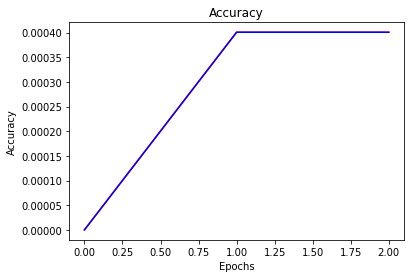

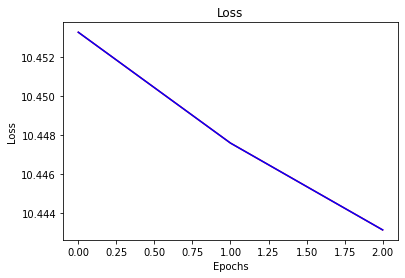

In [77]:
main(args)